In [1]:
import os
import os.path

from collections import OrderedDict

import torch
from torch import nn, optim

import numpy as np

from torch.utils.data import Dataset, DataLoader, sampler
from skimage import io

import pickle

from utils import *

In [65]:
class CIFAR10(Dataset):
    
    img_shape = (3, 32, 32)
    
    def __init__(self, folder, batch_size=32, num_workers=0, val_size=.2, seed=123):
        self.folder = folder
        
        with open(os.path.join(folder, 'batches.meta'), 'rb') as f:
            d = pickle.load(f, encoding='bytes')
            self.classes = list(map(lambda x: x.decode(), d[b'label_names']))
            
        self.collections = [
            io.imread_collection(os.path.join(folder, cls, '*.png'))
            for cls in self.classes
        ]
        
        data = []
        labels = []
        
        for filename in ['data_batch_%d' % i for i in range(1, 6)] + ['test_batch']:
            with open(os.path.join(folder, filename), 'rb') as f:
                d = pickle.load(f, encoding='bytes')
                imgs = d[b'data'].astype(float) / 255
                data.append(imgs.reshape([len(imgs)] + list(self.img_shape)))
                labels.append(np.array(d[b'labels']))
                
        del d, f, imgs, filename
        
        train_val_size = sum(map(len, data[:-1]))
        data = np.concatenate(data)
        labels = np.concatenate(labels)
        test_size = len(data) - train_val_size
        
        # Transpose data so its n_samples, n_channels, n_rows, n_cols
        # Also, transform it to float Tensor
        data = torch.Tensor(data).float()
        
        self.seed = seed
        rs = np.random.RandomState(seed)
        train_val = np.arange(train_val_size)
        rs.shuffle(train_val)
        
        test = np.arange(train_val_size, len(data))
        
        dataset_size = len(data)
        idx = np.arange(dataset_size)

        train_val_size = len(train_val)

        train_size = int(round(train_val_size * (1 - val_size)))
        val_size = train_val_size - train_size
        train, val = train_val[:train_size], train_val[train_size:]

        train_sampler = sampler.SubsetRandomSampler(train)
        val_sampler = sampler.SubsetRandomSampler(val)
        train_val_sampler = sampler.SubsetRandomSampler(train_val)
        test_sampler = sampler.SubsetRandomSampler(test)

        train_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
        val_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler)
        train_val_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=train_val_sampler)
        test_loader = DataLoader(self, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler)

        num_classes = len(self.classes)
        
        for k, v in locals().items():
            setattr(self, k, v)
        
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]
        cls = self.classes[y]
        
        return X, y, cls

In [66]:
dataset = CIFAR10(os.path.join('data', 'cifar-10-batches-py'))

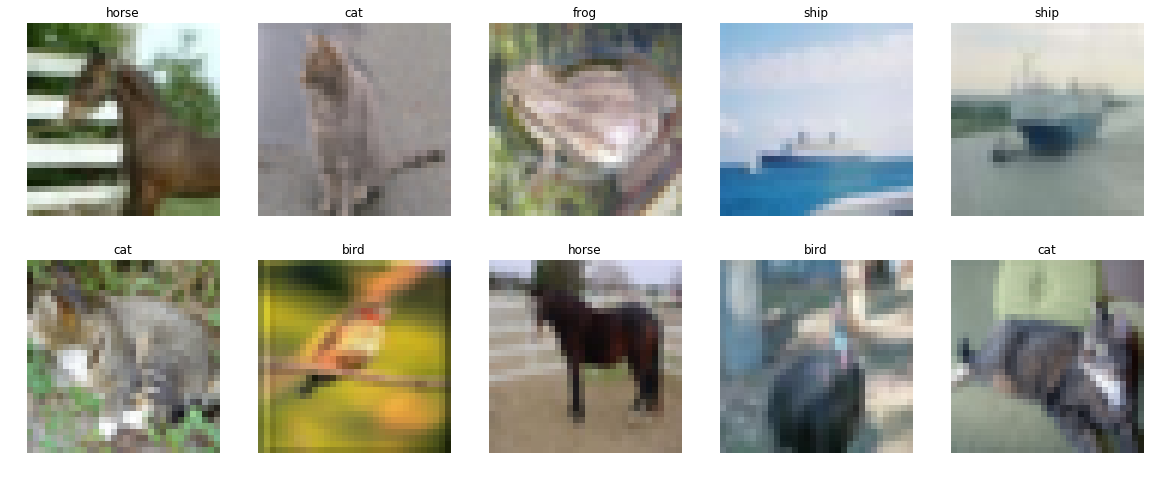

In [96]:
axes = subplots(2, 5).flatten()

for ax in axes:
    idx = np.random.choice(dataset.train_size)
    im, _, label = dataset[dataset.train[idx]]
    imshow(im, ax, title=label)